**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [1]:
NAME = "Christian Olivares-Rodriguez"

---

In [1]:
## import libraries needed
## make sure you run this code first!

library(testthat)
library(digest)
library(stringr)

## Question 1.

In class, we saw an example of kNN (k-Nearest Neighbors) model used for predicting concentration of nitrogen oxides (NOx) in Boston air, based on a single predictor - weighted average distance from 5 employment centers in Boston area. In this question you are going to tune the hyperparameter $k$, i.e. find its optimal value, and then fit the model with that value of $k$. But first, you will produce the following plot from class, which shows how performance of the fitted model varies with the tuning parameter $k$.

<img src="rmse_plots.png" style="width: 600px;"/>


We will use simple validation and split the data into `train` and `test` subsets.

To simplify, we first extract the two variables `nox` and `dist` from `Boston` data frame from `MASS` library, and create a new data frame called `df`. To do that, run the following cell.

Note that we rename `dist` and `nox` as `xall` and `yall`, respectively, and we will use these in the `kknn()` function below.

In [2]:
## RUN THIS CELL

library(MASS)
library(kknn)

n = nrow(Boston)  #number of observatons/rows, i.e. sample size

xall = Boston$dis  #our input variable
yall = 10*Boston$nox  #our output variable

# create data frame df that consists only of our input and output variables
df = data.frame(xall,yall) #simple data frame for convenience

dim(df) #checking the dimension of the dataframe df (note there are 506 obs)

[1] 506   2

### Part (a)


**In the following cell, use seed 123 in the function `set.seed()`** to make sure you produce the same (pseudo)random sample as in the test cells.

Then, create the vector `tr` which is a random sample of 400 indices from the index set: 1,2,3,...,506 (i.e. all rows in `df`). This will be the set of indices for our *training* data (hence the name `tr`). 

To create `tr`, use the `sample()` function.

You can check the documentation for the function `sample()` for details. Be sure to retain the default argument `replace = FALSE`.

If you set the seed to 123 before creating `tr`, first couple of values of `tr` should be

`415, 463, 179, 14, 195`

<br>

In [3]:
set.seed(123)

tr = sample(1:506, size = 400, replace = FALSE)


In [4]:
## check whether first 5 values of vector tr are 415, 463, 179, 14, 195

if (test_that(desc="", code={
    expect_equal(tr[1:5], c(415, 463, 179, 14, 195))
    }) != TRUE) stop("Sorry, wrong answer")


## check whether tr is of length 400

if (test_that(desc="", code={
    expect_equal(length(tr), 400)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎊
Test passed 🎉


In [5]:
## check whether tr is correct (hidden tests)



### Part (b)

Create data frames `train` and `test` from the data frame `df`. The data frame `train` should consist of observations (i.e. rows) of `df` whose indices are precisely those 400 random indices from vector `tr`. The data frame `test` should consist of the complement of `tr`, i.e. precisely those indices which are not in `tr`).

**Hint:** First two rows of `train` should be

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **xall** &nbsp; &nbsp; &nbsp; **yall** <br>
**415** `1.6582  6.93` 

**463** `2.7344  7.13
`

and of `test`:

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **xall** &nbsp; &nbsp; &nbsp; **yall** <br>
**1** `4.0900  5.38` 

**6** `6.0622  4.58`

In [6]:

# your code here
train = df[tr, ]

test_indices = setdiff(1:nrow(df), tr)

test = df[test_indices, ]

head(train, 2)
head(test, 2)



,xall,yall
,<dbl>,<dbl>
415,1.6582,6.93
463,2.7344,7.13


,xall,yall
,<dbl>,<dbl>
1,4.0900,5.38
6,6.0622,4.58


In [7]:

## check whether train and test are data frames and of right format

if (test_that(desc="", code={
    expect_equal(is.data.frame(train), TRUE)
    expect_equal(dim(train),c(400,2))
    }) != TRUE) stop("Sorry, train is not correct")

if (test_that(desc="", code={
    expect_equal(is.data.frame(test), TRUE)
    expect_equal(dim(test),c(506-400,2))
    }) != TRUE) stop("Sorry, test is not correct")


Test passed 🌈
Test passed 😸


In [8]:
## check whether the first two rows of train and test data are correct


if (test_that(desc="", code={
    expect_equal(norm(as.matrix(train[1:2,]) 
                      - matrix(c(1.6582, 6.93, 2.7344, 7.13),nrow=2,byrow=T), type="2") < 1.e-4,
                TRUE)
    }) != TRUE) stop("Sorry, train is not correct")

if (test_that(desc="", code={
    expect_equal(norm(as.matrix(test[1:2,]) 
                      - matrix(c(4.0900, 5.38, 6.0622, 4.58),nrow=2,byrow=T), type="2") < 1.e-4,
                TRUE)
    }) != TRUE) stop("Sorry, test is not correct")


Test passed 😸
Test passed 😸


In [9]:
## check whether train and test data are correct (hidden tests)



<br>

We now create vector `kvec` of possible values for the tuning parameter (i.e. hyperparameter) $k$ in the kNN model. We will take values 1,2,...,350. We could also include values up to the size of the training sample `train` (which is 400), but it's not difficult to see that the performance of the model for such values of $k$ would be lower than performance for all other values of $k$.

Apart from `kvec`, we also define `nk` to be the length of `kvec` (i.e. 350). Run the following cell to create `kvec` and `nk`.

In [10]:
## run this code to create kvec and define nk

kvec = 1:350
nk=length(kvec)


### Part (c)

In this part you should create vectors `outRMSE` and `inRMSE`. For each $k\in$ `kvec`, we fit the model using training data `train`. Then, we compute the out-of-sample root mean squared error $outRMSE_k$ as well as in-sample root mean squared error $inRMSE_k$:

$$outRMSE_k = \sqrt{{1\over n}\sum_{i\,\notin \,tr} (\hat{y}_i - y_i)^2}$$

$$inRMSE_k = \sqrt{{1\over n}\sum_{i\,\in \,tr} (\hat{y}_i - y_i)^2}$$

Note that the sum in $outRMSE_k$ goes over all indices that are NOT in the training index set `tr` while in $inRMSE_k$ the some goes precisely over those indices which ARE in the training index set `tr`.

<br>

To compute $outRMSE$ and $inRMSE$ we will need to find the fitted values $\hat{y}_i$'s, for $i\notin $`tr` and  
 
For this purpose, we use function `kknn()` from the library `kknn` (imported above). We can use a code line of the form 

`kmod = kknn(yall ~ xall, train=??, test=??, k=??, kernel="rectangular")`

where `yall ~ xall` is the R formula regressing the output `yall` on the input `xall`. The argument `train` is an appropriate data frame used for training/fitting, with columns named  `xall` and `yall`. Among other info, the created object `kmod` gives fitted values for the inputs in the `test` data frame.

Note that if want fitted values for the test data fame, using $k = 123$, we could use:

`kmod = kknn(yall ~ xall, train=train, test=test, k=123, kernel="rectangular")` and then 

`kmod$fitted` would be a vector of predicted y values for the `test` dataset.

If want to get fitted values for the training dataset, we would just use:

`kmodtr = kknn(yall ~ xall, train=train, test=train, k=123, kernel="rectangular")`

<br>

Your task is to do this for each $k\in$ `kvec` (not just $k=123$). Create a for-loop that for each $k \in$ `kvec` = $(1,2,...,\texttt{nk})$ computes $outRMSE_k$ and $inRMSE_k$ as given above and stores these values as $k$-th components of the R vectors `outRMSE` and `inRMSE`, respectively.

You can start by pre-allocating memory for `outRMSE` and `inRMSE`:

`outRMSE = rep(0,nk)` <br>
`inRMSE = rep(0,nk)`


If everything goes okay, the first couple of values of the two vectors are:

outRMSE = `0.776118930538112, 0.720259336484056, 0.688533442062602, 0.688563663027939, 0.713899101268837...`

inRMSE = `0.0294448637286709, 0.413066386916195, 0.479819913844999, 0.515748405687066, 0.532981421345998...`



In [11]:

outRMSE = rep(0,nk) #pre-allocating RMSE for out-of-sample data
inRMSE = rep(0,nk) #pre-allocating RMSE for in-sample data

# your code here

for (i in 1:nk) {
  k = kvec[i]
  
  kmod = kknn(yall ~ xall, train = train, test = test, k = k, kernel = "rectangular")
  
  test_predictions = fitted(kmod)

  outRMSE[i] = sqrt(mean((test_predictions - test$yall)^2))
  
  kmod_train = kknn(yall ~ xall, train = train, test = train, k = k, kernel = "rectangular")
  
  train_predictions = fitted(kmod_train)
    
  inRMSE[i] = sqrt(mean((train_predictions - train$yall)^2))
}


In [12]:
## check whether outRMSE and inRMSE are numeric vectors of length nk=350

if (test_that(desc="", code={
    expect_equal(is.numeric(outRMSE),TRUE)
    expect_equal(length(outRMSE)==350, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(is.numeric(inRMSE),TRUE)
    expect_equal(length(inRMSE)==350, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎉
Test passed 🎊


In [13]:
## check whether first couple of values of outRMSE are correct

if (test_that(desc="", code={
    expect_equal(norm(outRMSE[1:5]-c(0.776118930538112, 
                                0.720259336484056, 
                                0.688533442062602, 
                                0.688563663027939, 
                                0.713899101268837),type="2") < 1.e-5,TRUE)
    }) != TRUE) stop("Sorry, wrong answer")



Test passed 🌈


In [14]:
## check whether first couple of values of inRMSE are correct

if (test_that(desc="", code={
    expect_equal(norm(inRMSE[1:5]-c(0.0294448637286709, 
                                     0.413066386916195, 
                                     0.479819913844999, 
                                     0.515748405687066, 
                                     0.532981421345998),type="2") < 1.e-5,TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🌈



### Part (d)

Create plots showing both the test and train RMSE as functions of $k$ and $\ln{1/k}$. The latter is a measure of model complexity. That is, a smaller $k$ implies fewer neighbors are used by the model, and thus the model is more complex. Your plots should resemble the following:

<img src="rmse_plots.png" style="width: 750px;"/>


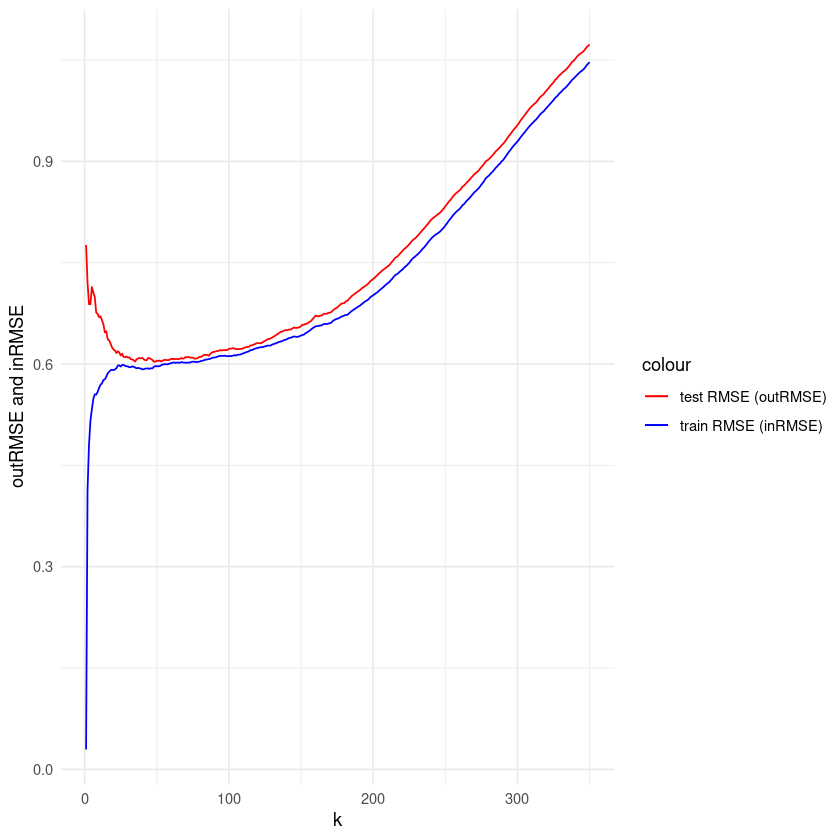

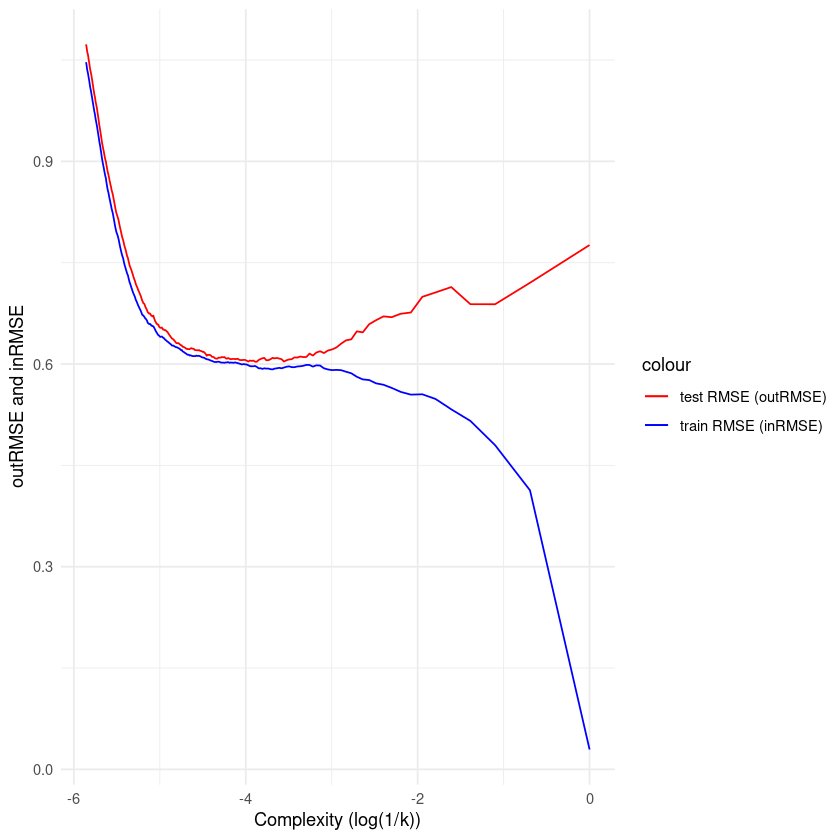

In [15]:
# your code here
library(ggplot2)
rmse_data = data.frame(k = kvec, outRMSE = outRMSE, inRMSE = inRMSE)

ggplot(rmse_data, aes(x = k)) +
  geom_line(aes(y = outRMSE, colour = "test RMSE (outRMSE)")) +
  geom_line(aes(y = inRMSE, colour = "train RMSE (inRMSE)")) +
  scale_color_manual(values = c("test RMSE (outRMSE)" = "red", "train RMSE (inRMSE)" = "blue")) +
  labs(x = "k", y = "outRMSE and inRMSE") +
  theme_minimal()

rmse_data$complexity = log(1 / rmse_data$k)

ggplot(rmse_data, aes(x = complexity)) +
  geom_line(aes(y = outRMSE, colour = "test RMSE (outRMSE)")) +
  geom_line(aes(y = inRMSE, colour = "train RMSE (inRMSE)")) +
  scale_color_manual(values = c("test RMSE (outRMSE)" = "red", "train RMSE (inRMSE)" = "blue")) +
  labs(x = "Complexity (log(1/k))", y = "outRMSE and inRMSE") +
  theme_minimal()


### Part (e)

Find $k$ for which the out-of-sample root mean squared error is the smallest. You may find the `which.min()` function helpful here.

Create variable `kbest` that stores the value $k$ for which `outRMSE` has the smallest value.

**Hint:** `kbest` should be between 40 and 50.

In [16]:

# your code here
best_index = which.min(outRMSE)

kbest = kvec[best_index]



In [17]:
## check whether kbest is between 40 and 50

if (test_that(desc="", code={
    expect_equal((40 <= kbest) & (kbest <= 50),TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 😸


In [18]:
## check whether kbest is correct (hidden tests)


### Part (f)

Construct a couple plots showing how model performs on both the training and testing data, and for different $k$.  For both data frames, show model predictions for $k = 5$, $k = 300$, and for $k$ equal to `kbest`, along with all the data points. You should obtain two plots that resemble the following:

<img src="k_performance.png" style="width: 750px;"/>


In [19]:
# your code here



<font style="font-size: 11pt;"><strong>IMPORTANT: In this problem, we fine-tuned the hyperparameter $k$. However, if we choose another training subsample even of the same sample size as above (for example, different seed), the result would be somewhat different (hopefully `kbest` wouldn't differ a lot). You should be aware of this randomness and the fact that `kbest` is not some absolutely optimal value of $k$.</strong></font>


## Question 2.


In order to include all the observations as training data at some point, and as validation data at some other time, we do cross-validation.

It is important to understand the idea of cross-validation from class and how it is implemented in code. Therefore, the task for this problem is to implement k-fold cross validation.

The general algorithm follows for 10-fold validation:

1. Suffle the data. Let `n` be the number of observations in total.

2. Get 10 blocks of indices of size `n/10`. If `n/10` is not an integer, then we have some leftover indices that we can distribute to the first `r` blocks, where `r` is the remainder of `n/10`.

3. Loop through each block of indices, using the data at these indices as the test data, while all other data is the train data. Train the model and get the RMSE for this block.

4. Take the average RMSE across the 10 blocks.

We run this algorithm for each $k$ of interest to determine our optimal $k$ value.

Let's implement the algorithm piecewise...

### Part 1

Recreate our data frame using the following cell:

In [20]:
xall = Boston$dis  #our input variable
yall = 10*Boston$nox  #our output variable

# create data frame df that consists only of our input and output variables
df = data.frame(xall,yall) 

#Number of observations
n = nrow(df)

<br>

Now, shuffle the dataframe by sampling all the indices without replacement; **for reproducibility, set your random number seed to `42`.**

That is, use the `sample()` function to give a new index vector, being sure to set `replace=F`. Then, use this vector to get a shuffled version of `df`. Assign this shuffled dataframe to `df` (i.e. replace `df`).

In [21]:
# your code here
xall = Boston$dis 
yall = 10*Boston$nox 
df = data.frame(xall, yall)

n = nrow(df)

set.seed(42)

shuffled_indices = sample(n, replace = FALSE)
df = df[shuffled_indices, ]

In [22]:
## check whether the first two rows of the shuffled dataframe are correct

if (test_that(desc="", code={
    expect_equal(norm(as.matrix(df[1:2,]) 
                      - matrix(c(5.8700, 4.480, 3.7240, 5.830),nrow=2,byrow=T), type="2") < 1.e-4,
                TRUE)
    }) != TRUE) stop("Sorry, shuffled df is not correct")


Test passed 😸


In [23]:
## check whether shuffled dataframe is correct (hidden tests)



### Part 2: Index blocks

Now, letting `nfolds` be a variable for the number of folds, we need to get the size of each fold, as well as the number of leftover indices.  For example, 103 observations divided into 10 folds leave 3 indices out.

The following block of code creates a **list of vectors**, called `index_blocks`, where each element is a vector of indices for a fold.  The leftover indices are assigned to the folds one-by-one, starting from beginning. This code divides 53 indices into 5 folds.

Run the cell and make sure you understand the logic.

In [24]:
#Suppose we have 53 indices that we need to divide among 5 folds:
nfolds = 5
N = 53

#Get fold size
foldsize = N %/% nfolds
remainder = N %% nfolds


#Empty list to build on
index_blocks = list()


for (i in 1:nfolds) {
    #Get this block of indices:
    idx = ((i-1)*foldsize+1):(i*foldsize)
    
    #Append to the list:
    index_blocks = append(index_blocks, list(idx))
}


#Now, assign the remainder:
base_i = foldsize*nfolds

for (i in 1:remainder) {
    index_blocks[[i]] = c(index_blocks[[i]], i + base_i)
}

#Display the first block:
index_blocks[[1]]

[1]  1  2  3  4  5  6  7  8  9 10 51

<br>

Adapt the code block above to give you a list of index vectors, also called `index_blocks`, for 10 folds, and for `n` (little `n`) indices, with `n` the number of observations in our data frame.


In [25]:
# your code here
nFolds = 10

foldSize = n %/% nFolds
remainder = n %% nFolds

index_blocks = list()

for (i in 1:nFolds) {
    
  idx = ((i - 1) * foldSize + 1):(i * foldSize)
  
  index_blocks = append(index_blocks, list(idx))
}

base_i = foldSize * nFolds
for (i in 1:remainder) {
  index_blocks[[i]] = c(index_blocks[[i]], i + base_i)
}

index_blocks[[1]]

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
[20]  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
[39]  39  40  41  42  43  44  45  46  47  48  49  50 501

In [26]:
## check whether the first element of index_blocks is correct

correct_b1 = c(seq(1,50), 501)

if (test_that(desc="", code={
    expect_equal(all(index_blocks[[1]] == correct_b1),
                TRUE)
    }) != TRUE) stop("Sorry, first element of index_blocks not correct")


Test passed 🌈


In [27]:
## check whether index_blocks is correct (hidden tests)


### Parts 3/4

Loop through each block of indices (each fold), using each group of indices to define your validation dataset, while all other data is used for training. Train a KNN model with `k = 100` and calculate the RMSE for each fold. You may find it helpful to define a helper `rmse()` function.

Finally, take the mean RMSE across all folds. Store this value as `mean_rmse` (all lowercase).

In [34]:
# your code here

    

In [35]:
## check whether whether 4th and 5th dec. digits of mean_rmse are 92

if (test_that(desc="", code={
    expect_equal( (floor(mean_rmse*10^5) %% 100 == 92), TRUE)
    }) != TRUE) stop("Sorry, your CI is incorrect.")

── Error (<text>:4:5):  ────────────────────────────────────────────────────────
Error: object 'mean_rmse' not found
Backtrace:
 1. testthat::expect_equal(...)
 2. testthat::quasi_label(enquo(object), label, arg = "object")
 3. rlang::eval_bare(expr, quo_get_env(quo))



ERROR: Error in eval(expr, envir, enclos): Sorry, your CI is incorrect.


In [ ]:
## check whether the answer is correct (hidden test)


### All Together Now

Now, let's put everything together into a single function. Implement a function, `knn_CV` that takes the following arguments:

1. `df`: Dataframe to train/test KNN model on. `df` is expected to have `xall` and `yall` as the only variables.

2. `nfolds`: Number of folds for cross-validation

3. `kvec`: A **vector** of `k` values for which cross-validation will be performed.

The function should:

1. Shuffle the dataframe
2. Perform cross-validation for the specified number of folds, assigning the remainder indices as above
3. Return a vector of mean RMSE values, corresponding to each `k` value in the `kvec` vector.

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer


<br>

Use this function to find the mean RMSE vector under cross-validation for the following sets of parameters:

1. `nfolds = 5`, `kvec = 1:250`
2. `nfolds = 10`, `kvec = 1:250`
3. `nfolds = 15`, `kvec = 1:250`

Plot the mean RMSE for each case against $\ln{1/k}$. Your final plot should look something like the following:

<img src="final_fig.png" style="width: 700px;"/>


In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer
